In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing


In [3]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [4]:
# source: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#COVID19_line_list_data.csv
cor = pd.read_csv('comprehensive_dataset_updated_03_20/covid_19_data.csv')

In [24]:
# source: https://www.kaggle.com/imdevskp/ebola-outbreak-20142016-complete-dataset#ebola_2014_2016_clean.csv
ebola = pd.read_csv('ebola-outbreak-20142016-complete-dataset/ebola_2014_2016_clean.csv')

In [6]:
# source: https://www.kaggle.com/imdevskp/mers-outbreak-dataset-20122019#country_count_latest.csv
mers = pd.read_csv('mers-outbreak-dataset-20122019-week/country_count_latest.csv')

In [7]:
# source: https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset#sars_2003_complete_dataset_clean.csv
sars = pd.read_csv('sars-outbreak-2003-complete-dataset/sars_2003_complete_dataset_clean.csv')

In [8]:
# source: https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy
life_exp = pd.read_csv('life_expectancy.csv', encoding= 'unicode_escape')

In [9]:
# source: https://en.wikipedia.org/wiki/List_of_countries_by_age_structure
popage = pd.read_csv('population_age.csv', encoding= 'unicode_escape')

In [10]:
# source: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density
popden = pd.read_csv('population_density.csv', encoding= 'unicode_escape')

#### Clean mers

In [11]:
mers = mers.rename(columns={'Confirmed':'mers_confirmed'})
mers.loc[mers['Country'] == 'United States of America', 'Country'] = 'US'

#### sars data preprocessing

In [12]:
sars = sars.rename(columns={'Cumulative number of case(s)':'sars_confirmed', 'Number of deaths':'sars_deaths', 'Number recovered':'sars_recovered'})

In [13]:
sars.loc[sars['Country']=='Hong Kong SAR, China', 'Country'] = 'Hong Kong'
sars.loc[sars['Country'] == 'Macao SAR, China', 'Country'] = 'Macau'
sars.loc[sars['Country'] == 'Taiwan, China', 'Country'] = 'Taiwan'
sars.loc[sars['Country'] == 'Viet Nam', 'Country'] = 'Vietnam'
sars.loc[sars['Country'] == 'United States', 'Country'] = 'US'

In [14]:
# includes cumulative number of cases 
sars = sars.sort_values(by="Date").drop_duplicates(subset=["Country"], keep="last").reset_index(drop=True)

#### life_exp cleaning

In [15]:
life_exp = life_exp.rename(columns = {'Country/Region':'Country', 'Overall':'life_exp_score'})

In [20]:
life_exp['Country'] = life_exp['Country'].str.replace(u'\xa0', '')
life_exp_count = ['United States', "People's Republic of China", 'Ireland']
cor_country_names = ['US', 'China', 'Republic of Ireland']
for i in range(len(cor_country_names)):
    life_exp.loc[life_exp['Country'] == life_exp_count[i], 'Country'] = cor_country_names[i]


#### cor (country table)

In [18]:
cor.loc[cor['Country/Region'] == 'Mainland China',  'Country/Region'] = 'China'
cor.loc[cor['Country/Region'] == 'UK',  'Country/Region'] = 'United Kingdom'

In [34]:
cor = cor.rename(columns = {'Country/Region':'Country'})

In [35]:
cor_sorted = cor.sort_values(by="ObservationDate").drop_duplicates(subset=["Country","Province/State"], keep="last").reset_index(drop=True)

#### ebola preprocessing

In [26]:
#ebalo table cleaning
ebola = ebola.sort_values(by="Date").drop_duplicates(subset=["Country"], keep="last").reset_index(drop=True)

In [27]:
ebola = ebola[['Country', 'No. of confirmed cases', 'No. of confirmed deaths']]
ebola = ebola.rename(columns = {'No. of confirmed cases':'eb_confirmed', 'No. of confirmed deaths':'eb_deaths', })

In [28]:
ebola.loc[ebola['Country'] == 'United States of America', 'Country'] = 'US'

#### Population ratio cleaning

In [29]:
popage['Country'] = popage['Country'].str.replace(u'\xa0', '')
popage_countries = ['United States', 'Eswatini (Swaziland)', 'Ireland']
in_group_country = ['US', 'Eswatini', 'Republic of Ireland']
for i in range(len(in_group_country)):
    popage.loc[popage['Country'] == popage_countries[i], 'Country'] = in_group_country[i]

In [30]:
for col in popage.columns[1:]:
    popage[col] = popage[col].str.replace(r'[\xa0%]','', regex=True).astype(float)
popage.columns = ['Country', '0-14', '15-65', 'Over 65']

#### Population Density cleaning

In [31]:
popden = popden[['Country (or dependent territory)', 'Density']][4:]
popden.columns = ['Country','Density']
popden['Country'] = popden['Country'].str.replace(r'^\s+','', regex=True)

In [32]:
popden['Density'] = popden['Density'].str.replace(u',', '').astype(int)
popden_countries = ['United States', 'Eswatini (Swaziland)', 'Russia[note 6]', 'Ukraine [note 4]', 'Uruguay[note 5]']
in_group_country = ['US', 'Eswatini', 'Russia',  'Ukraine', 'Uruguay']
for i in range(len(in_group_country)):
    popden.loc[popden['Country'] == popden_countries[i], 'Country'] = in_group_country[i]

#### Start merging

In [36]:
cor_grouped = cor_sorted.groupby(['Country']).agg({'ObservationDate':'last', 
                                                  'Confirmed':'sum',
                                                  'Deaths':'sum',
                                                  'Recovered':'sum'})

In [37]:
# merge with ebola data
cor_eb = pd.merge(cor_grouped, ebola, on='Country', how='left')

In [38]:
# fill Nan confimed ebola with 0 (no ebola)
cor_eb.loc[cor_eb['eb_confirmed'].isna(), 'eb_confirmed'] = 0
cor_eb.loc[cor_eb['eb_deaths'].isna(), 'eb_deaths'] = 0

In [39]:
# merge with mers cov
cor_eb_mers = pd.merge(cor_eb, mers, on='Country', how='left')

In [40]:
# fill with 0
cor_eb_mers.loc[cor_eb_mers['mers_confirmed'].isna(), 'mers_confirmed'] = 0

In [41]:
# merge with life Expectancy score
cor_eb_mers_life = pd.merge(cor_eb_mers, life_exp[['Country', 'life_exp_score']], on='Country', how='left')
# only 6% has null life exp score

In [42]:
# merge with age population ratio 
cor_with_age = pd.merge(cor_eb_mers_life, popage, on = 'Country', how='left')

In [43]:
# merge with population density
cor_dens = pd.merge(cor_with_age, popden, on='Country', how='left')

In [44]:
# merge with sars
cor_comp = pd.merge(cor_dens, sars, on='Country', how='left')

In [45]:
cor_comp.loc[cor_comp['sars_confirmed'].isna(), 'sars_confirmed'] = 0
cor_comp.loc[cor_comp['sars_deaths'].isna(), 'sars_deaths'] = 0
cor_comp.loc[cor_comp['sars_recovered'].isna(), 'sars_recovered'] = 0

In [46]:
len(cor_comp)

184

In [47]:
len(cor_comp[~cor_comp['life_exp_score'].isna()])

138

In [46]:
cor_comp.corr()

,Confirmed,Deaths,Recovered,eb_confirmed,eb_deaths,mers_confirmed,life_exp_score,0-14,15-65,Over 65,Density,sars_confirmed,sars_deaths,sars_recovered
Confirmed,1.000000,0.922759,0.868705,-0.013730,-0.013970,-0.010550,0.171734,-0.179697,0.097910,0.183919,0.600554,0.778039,0.607066,0.789275
Deaths,0.922759,1.000000,0.714722,-0.010829,-0.011081,-0.010504,0.142554,-0.144581,0.069821,0.156500,0.466226,0.611188,0.476717,0.620190
Recovered,0.868705,0.714722,1.000000,-0.006601,-0.006597,-0.006345,0.044724,-0.076077,0.099641,0.021348,0.678931,0.936311,0.737367,0.949336
eb_confirmed,-0.013730,-0.010829,-0.006601,1.000000,0.999997,-0.006053,-0.160602,0.145654,-0.141648,-0.088349,-0.016910,-0.008230,-0.009618,-0.007938
eb_deaths,-0.013970,-0.011081,-0.006597,0.999997,1.000000,-0.006028,-0.160130,0.145336,-0.141221,-0.088275,-0.017187,-0.008205,-0.009577,-0.007914
mers_confirmed,-0.010550,-0.010504,-0.006345,-0.006053,-0.006028,1.000000,0.012854,-0.005497,0.104599,-0.092876,-0.007464,-0.008495,-0.010094,-0.008172
life_exp_score,0.171734,0.142554,0.044724,-0.160602,-0.160130,0.012854,1.000000,-0.851170,0.622314,0.725728,-0.038065,0.079040,0.122670,0.073840
0-14,-0.179697,-0.144581,-0.076077,0.145654,0.145336,-0.005497,-0.851170,1.000000,-0.779970,-0.794205,-0.009743,-0.117536,-0.154303,-0.111378
15-65,0.097910,0.069821,0.099641,-0.141648,-0.141221,0.104599,0.622314,-0.779970,1.000000,0.239307,0.050217,0.136054,0.161361,0.131109
Over 65,0.183919,0.156500,0.021348,-0.088349,-0.088275,-0.092876,0.725728,-0.794205,0.239307,1.000000,-0.033147,0.050325,0.082783,0.045573


In [233]:
cor_comp_2.corr()

,SNo,Confirmed,Deaths,Recovered,eb_confirmed,eb_deaths,mers_confirmed,life_exp_score,0-14,15-65,Over 65,Density,sars_confirmed,sars_deaths,sars_recovered
SNo,1.000000,0.078542,0.122982,0.047409,0.308492,0.023168,0.265912,0.117357,0.103154,-0.320630,0.210649,-0.170613,-0.219586,-0.311162,-0.210857
Confirmed,0.078542,1.000000,0.622057,0.815396,-0.505691,-0.033114,-0.422274,-0.230779,-0.202566,0.552314,-0.345782,0.336675,0.369725,0.523648,0.355793
Deaths,0.122982,0.622057,1.000000,0.588116,-0.211498,-0.013217,-0.187580,-0.038857,-0.124497,0.156160,-0.051643,0.145931,0.124129,0.191812,0.128380
Recovered,0.047409,0.815396,0.588116,1.000000,-0.517166,-0.031583,-0.459661,-0.279283,-0.187390,0.607479,-0.404725,0.412411,0.441150,0.584479,0.409239
eb_confirmed,0.308492,-0.505691,-0.211498,-0.517166,1.000000,0.103130,0.643849,0.147981,0.187967,-0.581007,0.380772,-0.008704,-0.214704,-0.614424,-0.324759
eb_deaths,0.023168,-0.033114,-0.013217,-0.031583,0.103130,1.000000,0.032257,-0.017928,0.048872,-0.049326,0.009673,-0.009041,-0.019265,-0.037454,-0.022579
mers_confirmed,0.265912,-0.422274,-0.187580,-0.459661,0.643849,0.032257,1.000000,0.192024,0.197301,-0.596763,0.389002,-0.264470,-0.453882,-0.673821,-0.437311
life_exp_score,0.117357,-0.230779,-0.038857,-0.279283,0.147981,-0.017928,0.192024,1.000000,-0.651303,-0.443212,0.837421,-0.615348,-0.294633,-0.314561,-0.249864
0-14,0.103154,-0.202566,-0.124497,-0.187390,0.187967,0.048872,0.197301,-0.651303,1.000000,-0.203415,-0.509869,0.080782,-0.219129,-0.258279,-0.181963
15-65,-0.320630,0.552314,0.156160,0.607479,-0.581007,-0.049326,-0.596763,-0.443212,-0.203415,1.000000,-0.738535,0.505577,0.657836,0.801324,0.572679


In [48]:
cor_comp_model = cor_comp[~cor_comp['life_exp_score'].isna()]

In [49]:
len(cor_comp_model), len(cor_comp)

(138, 184)

In [50]:
cor_comp_model['ObservationDate'] = pd.to_datetime(cor_comp_model['ObservationDate'])
le = preprocessing.LabelEncoder()
cor_comp_model['Day_number'] = le.fit_transform(cor_comp_model['ObservationDate'])

c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [601]:
cor_comp_2.corr()

,SNo,Confirmed,Deaths,Recovered,eb_confirmed,eb_deaths,mers_confirmed,life_exp_score,0-14,15-65,Over 65,Density,sars_confirmed,sars_deaths,sars_recovered,Day_number
SNo,1.000000,0.097978,0.092903,-0.021887,0.154750,0.052291,0.075877,-0.107676,0.213764,-0.286735,0.001741,-0.311580,-0.340559,-0.362809,-0.340719,0.960475
Confirmed,0.097978,1.000000,0.624327,0.780421,-0.319831,-0.058056,-0.121547,0.074350,-0.268793,0.430448,-0.064374,0.327060,0.408418,0.526138,0.412111,0.094729
Deaths,0.092903,0.624327,1.000000,0.607508,-0.134172,-0.018404,-0.051787,0.050519,-0.114423,0.141002,0.009976,0.180956,0.163459,0.211920,0.166018,0.109156
Recovered,-0.021887,0.780421,0.607508,1.000000,-0.312230,-0.033615,-0.155692,-0.017537,-0.222744,0.477968,-0.161073,0.448573,0.546438,0.650076,0.550158,0.039169
eb_confirmed,0.154750,-0.319831,-0.134172,-0.312230,1.000000,0.454031,0.243736,0.005669,0.036515,-0.286301,0.211202,0.212535,0.031089,-0.351808,0.025850,0.164734
eb_deaths,0.052291,-0.058056,-0.018404,-0.033615,0.454031,1.000000,-0.023862,-0.235837,0.211838,-0.163883,-0.104502,-0.024777,-0.059583,-0.037001,-0.059065,0.044460
mers_confirmed,0.075877,-0.121547,-0.051787,-0.155692,0.243736,-0.023862,1.000000,0.068869,-0.019552,0.134370,-0.096184,-0.060957,-0.186375,-0.308508,-0.189960,0.088948
life_exp_score,-0.107676,0.074350,0.050519,-0.017537,0.005669,-0.235837,0.068869,1.000000,-0.775788,0.193412,0.745087,-0.082451,0.067726,-0.042564,0.063605,-0.084024
0-14,0.213764,-0.268793,-0.114423,-0.222744,0.036515,0.211838,-0.019552,-0.775788,1.000000,-0.565178,-0.680327,-0.196949,-0.374484,-0.290197,-0.372657,0.197141
15-65,-0.286735,0.430448,0.141002,0.477968,-0.286301,-0.163883,0.134370,0.193412,-0.565178,1.000000,-0.220078,0.331663,0.553792,0.624078,0.555360,-0.282099


In [51]:
cor_comp_2 = cor_comp_model.copy()

In [52]:
# apply log to selected columns
cor_comp_2[['Confirmed','Deaths','Recovered','eb_confirmed','eb_deaths', 'mers_confirmed', 'Density'
         , 'sars_confirmed', 'sars_deaths', 'sars_recovered']] = cor_comp_model[['Confirmed','Deaths','Recovered','eb_confirmed','eb_deaths', 'mers_confirmed', 'Density'
         , 'sars_confirmed', 'sars_deaths', 'sars_recovered']].apply(lambda x:np.log(x))

cor_comp_2.replace([np.inf, -np.inf], 0, inplace=True)


c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
regr = linear_model.LinearRegression()

In [54]:
# 'eb_deaths','life_exp_score','Over 65','Day_number','sars_recovered', 'mers_confirmed', '0-14',sars_deaths
x = cor_comp_2[['Density', 'eb_confirmed', 'eb_deaths',
          'sars_confirmed','15-65','life_exp_score','mers_confirmed','Over 65','sars_deaths']]
y = cor_comp_2['Confirmed']
# x.replace([np.inf, -np.inf], 0, inplace=True) 
# y.replace([np.inf, -np.inf], 0, inplace=True)

In [55]:
from sklearn.impute import KNNImputer

In [56]:
imputer = KNNImputer(n_neighbors=10)

In [57]:
x = imputer.fit_transform(x)
# y = np.reshape(y, (-1,1))
# y = imputer.fit_transform(y)

In [58]:
split_75 = int(len(x)*0.75)

In [59]:
split_75 = int(len(x)*0.75)
x_train, x_test = x[:split_75], x[split_75:]
y_train, y_test = y[:split_75], y[split_75:]

In [60]:
model = regr.fit(x_train, y_train)

In [61]:
y_pred = model.predict(x_test)

In [62]:
rms = sqrt(mean_squared_error(y_test, y_pred))

In [63]:
rms

1.412978085391468

In [64]:
np.exp(y_pred[0:20])

array([8.37488787e+01, 2.20631835e+02, 2.73233416e+02, 1.07818661e+01,
       6.79578032e+00, 2.25390259e+00, 1.53169981e+04, 1.05635202e+01,
       1.13550791e+02, 2.66252861e+00, 2.49050924e+02, 1.02944819e+02,
       1.63954768e+02, 1.59296778e+01, 8.07156196e+02, 1.44328255e+03,
       1.21156204e+02, 1.24541653e+01, 4.61959794e+00, 1.02478128e+03])

In [69]:
cor_comp_model[split_75:][27:31]['Country']

174                      US
175                 Ukraine
176    United Arab Emirates
177                 Uruguay
Name: Country, dtype: object

In [75]:
y_test[6:11]

147    5.613128
148    3.433987
149    4.634729
150    1.791759
151    5.843544
Name: Confirmed, dtype: float64

In [71]:
y_pred[5:10]

array([0.8126632 , 9.63671847, 2.35740657, 4.73225024, 0.97927628])

Text(0.5, 1.0, 'COV-19 Predictions Based on Linear Regression Model')

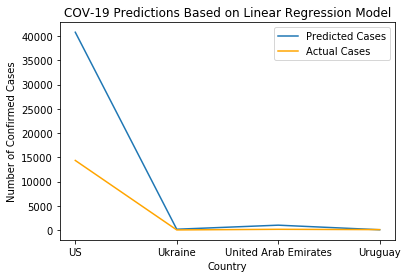

In [74]:
plt.plot(list(cor_comp_model[split_75:][27:31]['Country']), np.exp(y_pred[27:31]), color='#1f77b4')
plt.plot(list(cor_comp_model[split_75:][27:31]['Country']), np.exp(y_test[27:31]), color = 'orange')
plt.legend(labels=['Predicted Cases', 'Actual Cases'])
plt.xlabel('Country')
plt.ylabel('Number of Confirmed Cases')
plt.title('COV-19 Predictions Based on Linear Regression Model')
# plt.ylim(0,50000)

Text(0.5, 1.0, 'Cov-19 and Health Systems')

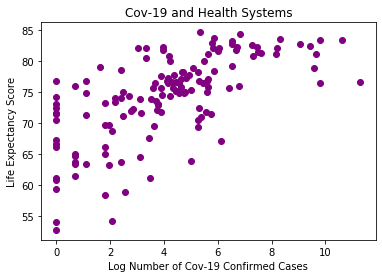

In [69]:
plt.scatter(np.log(cor_comp_model['Confirmed']), (cor_comp_model['life_exp_score']), color='purple')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Life Expectancy Score')
plt.title('Cov-19 and Health Systems')

Text(0.5, 1.0, 'Cov-19 and Health Systems')

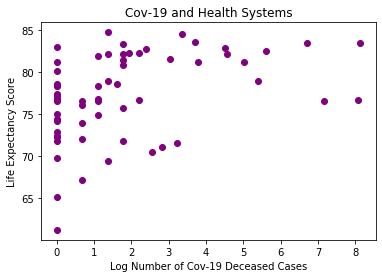

In [74]:
plt.scatter(np.log(cor_comp_model['Deaths']), (cor_comp_model['life_exp_score']), color='purple')
plt.xlabel('Log Number of Cov-19 Deceased Cases')
plt.ylabel('Life Expectancy Score')
plt.title('Cov-19 and Health Systems')

Text(0.5, 1.0, 'Cov-19 and Health Systems')

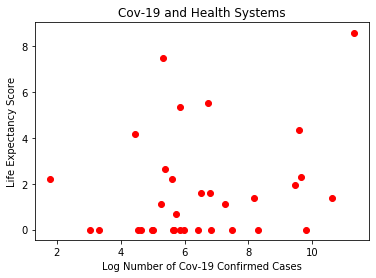

In [215]:
plt.scatter(np.log(cor_comp_model['Confirmed']), np.log(cor_comp_model['sars_confirmed']), color='red')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Life Expectancy Score')
plt.title('Cov-19 and Health Systems')

c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Cov-19 and Health Systems')

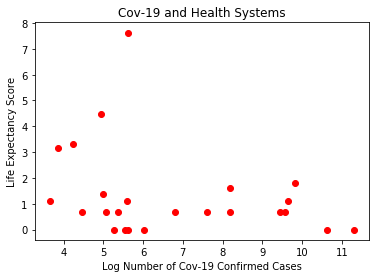

In [228]:
plt.scatter(np.log(cor_comp_model['Confirmed']), np.log(cor_comp_model['mers_confirmed']), color='red')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Life Expectancy Score')
plt.title('Cov-19 and Health Systems')

Text(0.5, 1.0, 'Cov-19 and Population Density')

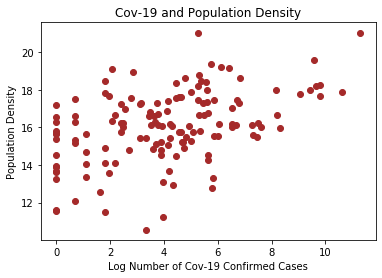

In [221]:
plt.scatter(np.log(cor_comp_model['Confirmed']), np.log(cor_comp_model['Density']), color='brown')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Population Density')
plt.title('Cov-19 and Population Density')

Text(0.5, 1.0, 'Cov-19 and Density')

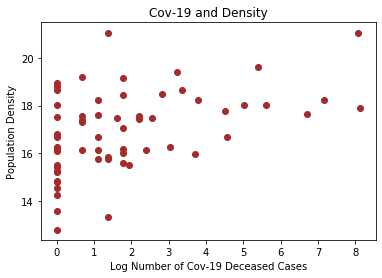

In [220]:
plt.scatter(np.log(cor_comp_model['Deaths']), np.log(cor_comp_model['Density']), color='brown')
plt.xlabel('Log Number of Cov-19 Deceased Cases')
plt.ylabel('Population Density')
plt.title('Cov-19 and Density')

Text(0.5, 1.0, 'Cov-19 and Population')

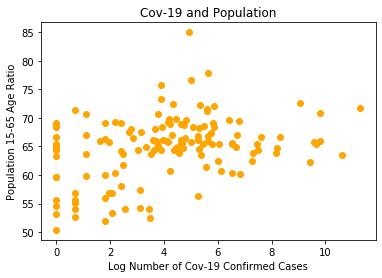

In [81]:
plt.scatter(np.log(cor_comp_model['Confirmed']), (cor_comp_model['15-65']), color='Orange')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Population 15-65 Age Ratio')
plt.title('Cov-19 and Population')

Text(0.5, 1.0, 'Cov-19 and Population')

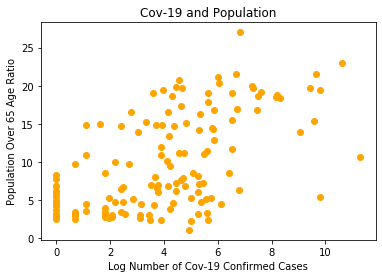

In [82]:
plt.scatter(np.log(cor_comp_model['Confirmed']), (cor_comp_model['Over 65']), color='Orange')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Population Over 65 Age Ratio')
plt.title('Cov-19 and Population')

Text(0.5, 1.0, 'Cov-19 and Population')

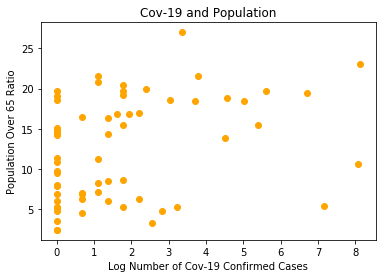

In [80]:
plt.scatter(np.log(cor_comp_model['Deaths']), (cor_comp_model['Over 65']), color='Orange')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Population Over 65 Ratio')
plt.title('Cov-19 and Population')

Text(0.5, 1.0, 'Cov-19 and Population')

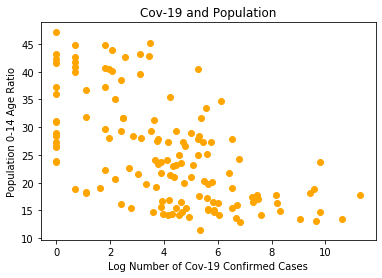

In [219]:
plt.scatter(np.log(cor_comp_model['Confirmed']), (cor_comp_model['0-14']), color='Orange')
plt.xlabel('Log Number of Cov-19 Confirmed Cases')
plt.ylabel('Population 0-14 Age Ratio')
plt.title('Cov-19 and Population')

In [330]:
0.11e164

1.1e+163

In [83]:
top_sars = cor_comp_model.sort_values(by='sars_confirmed', ascending=False, inplace=False, kind='quicksort', na_position='last')[:5]

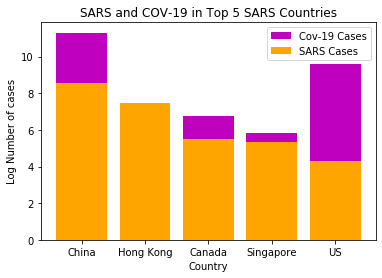

In [84]:
plt.bar(top_sars['Country'],np.log(top_sars['Confirmed']), color='m')
plt.bar(top_sars['Country'],np.log(top_sars['sars_confirmed']), color='orange')
plt.title('SARS and COV-19 in Top 5 SARS Countries')
plt.xlabel('Country')
plt.ylabel('Log Number of cases')
plt.legend(['Cov-19 Cases', 'SARS Cases'])

In [85]:
top_conf = cor_comp_model.sort_values(by='Confirmed', ascending=False, inplace=False, kind='quicksort', na_position='last')[:5]

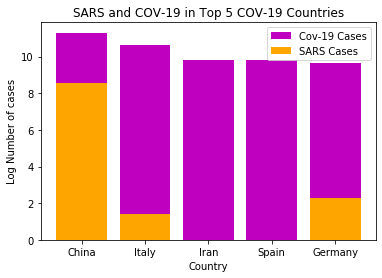

In [89]:
plt.bar(top_conf['Country'],np.log(top_conf['Confirmed']), color='m')
plt.bar(top_conf['Country'],np.log(top_conf['sars_confirmed']), color='orange')
plt.title('SARS and COV-19 in Top 5 COV-19 Countries')
plt.xlabel('Country')
plt.ylabel('Log Number of cases')
plt.legend(['Cov-19 Cases', 'SARS Cases'])

In [90]:
top_ebola = cor_comp_model.sort_values(by='eb_confirmed', ascending=False, inplace=False, kind='quicksort', na_position='last')[:5]

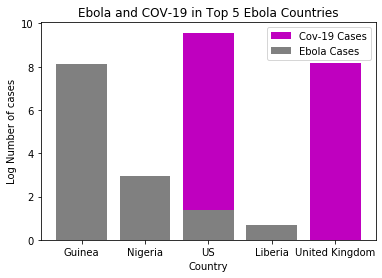

In [91]:
plt.bar(top_ebola['Country'],np.log(top_ebola['Confirmed']), color='m')
plt.bar(top_ebola['Country'],np.log(top_ebola['eb_confirmed']), color='gray')
plt.title('Ebola and COV-19 in Top 5 Ebola Countries')
plt.xlabel('Country')
plt.ylabel('Log Number of cases')
plt.legend(['Cov-19 Cases', 'Ebola Cases'])

c:\users\owner\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


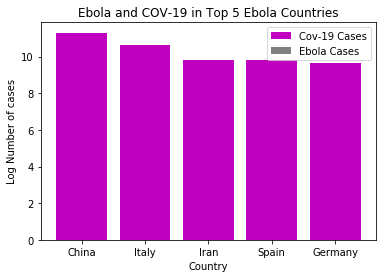

In [92]:
plt.bar(top_conf['Country'],np.log(top_conf['Confirmed']), color='m')
plt.bar(top_conf['Country'],np.log(top_conf['eb_confirmed']), color='gray')
plt.title('Ebola and COV-19 in Top 5 Ebola Countries')
plt.xlabel('Country')
plt.ylabel('Log Number of cases')
plt.legend(['Cov-19 Cases', 'Ebola Cases'])